In [11]:
import os
import numpy as np
import pandas as pd

# depth_noise_dataset_01
experiment_path = "../mlruns/381621903030839580/"

# depth_noise_dataset_02
#experiment_path = "../mlruns/972687907078296051/"

run_paths = [os.path.join(experiment_path, name) for name in os.listdir(experiment_path) if os.path.isdir(os.path.join(experiment_path, name))]


experiment_df = pd.DataFrame()
for rp in run_paths:
    #print(rp)


    # load params
    params_df = pd.DataFrame()
    params_path = os.path.join(rp, "params")
    for param_name in os.listdir(params_path):
        param_file = os.path.join(params_path, param_name)
        df = pd.read_csv(param_file, sep=' ', header=None)
        #df.columns = ['Value']
        params_df[param_name] = df[0]
        #run_df[metric_name] = metric_df['Value']

    # Add run_path as identifier for the run
    params_df['run_path'] = rp

    metrics_df = pd.DataFrame()
    metrics_path = os.path.join(rp, "metrics") 
    for metric_name in os.listdir(metrics_path):
        metric_file = os.path.join(metrics_path, metric_name)

        df = pd.read_csv(metric_file, sep=' ', header=None)
        df.columns = ['Timestamp', 'Value', 'Index']

        if metrics_df.empty:
            metrics_df["step"] = df['Index']

        metrics_df[metric_name] = df['Value']

        ###

    if not params_df.empty and not metrics_df.empty:
        df1_repeated = pd.concat([params_df]*metrics_df.shape[0], ignore_index=True)
        run_df = pd.concat([df1_repeated, metrics_df], axis=1)
        #print(result_horizontal)
        #break

        experiment_df = pd.concat([experiment_df, run_df], axis=0, ignore_index=True)



In [12]:
experiment_df.columns

Index(['experiment_name', 'device_index', 'seed', 'hidden_width',
       'hidden_depth', 'steps', 'grid', 'k', 'mode', 'base_fun',
       'spline_noise_scale', 'init_mode', 'sp_trainable', 'sb_trainable',
       'affine_trainable', 'update_grid', 'dataset', 'moon_noise_level',
       'random_distribution', 'random_input_dim', 'random_output_dim',
       'random_uniform_range_min', 'random_uniform_range_max',
       'random_normal_mean', 'random_normal_std', 'symbolic_regression',
       'plot_initialized_model', 'plot_trained_model', 'save_video',
       'save_model', 'spline_noise_scale_class', 'run_path', 'step',
       'train_loss', 'test_loss', 'reg', 'train_acc', 'test_acc',
       'classifier_probe_train_accuracy', 'classifier_probe_test_accuracy'],
      dtype='object')

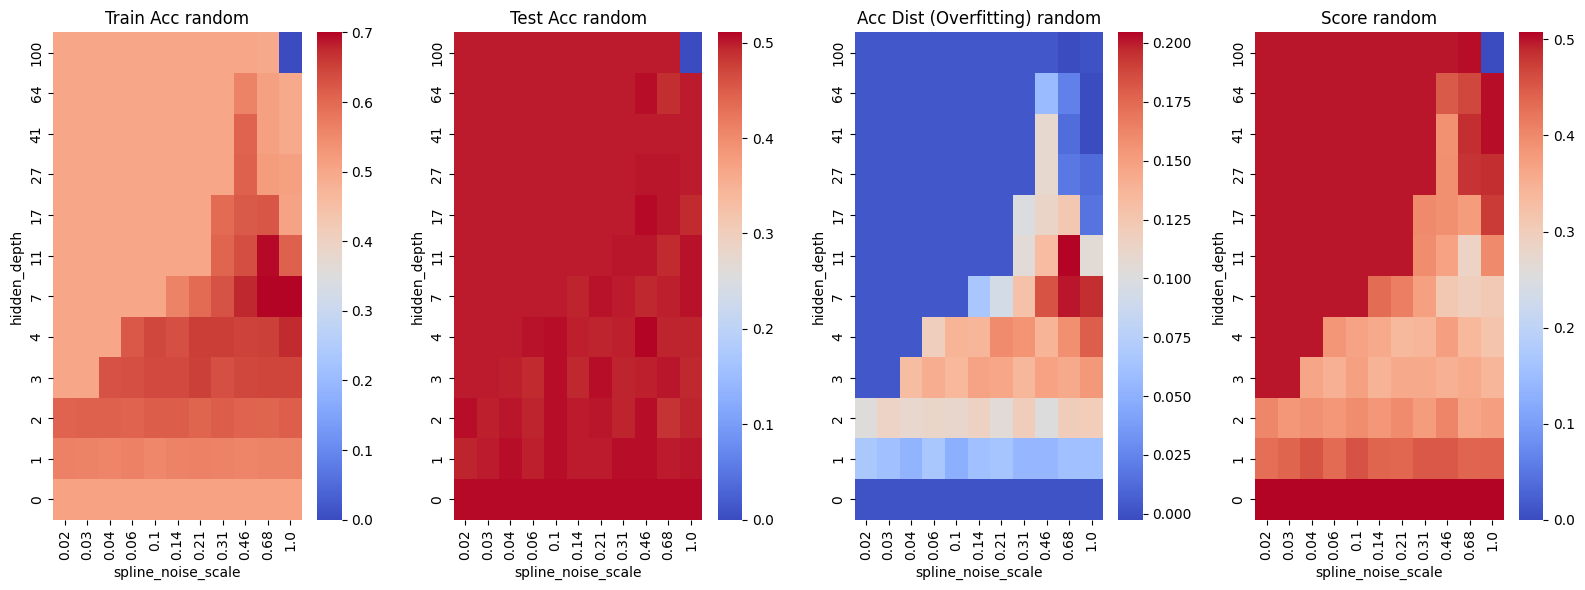

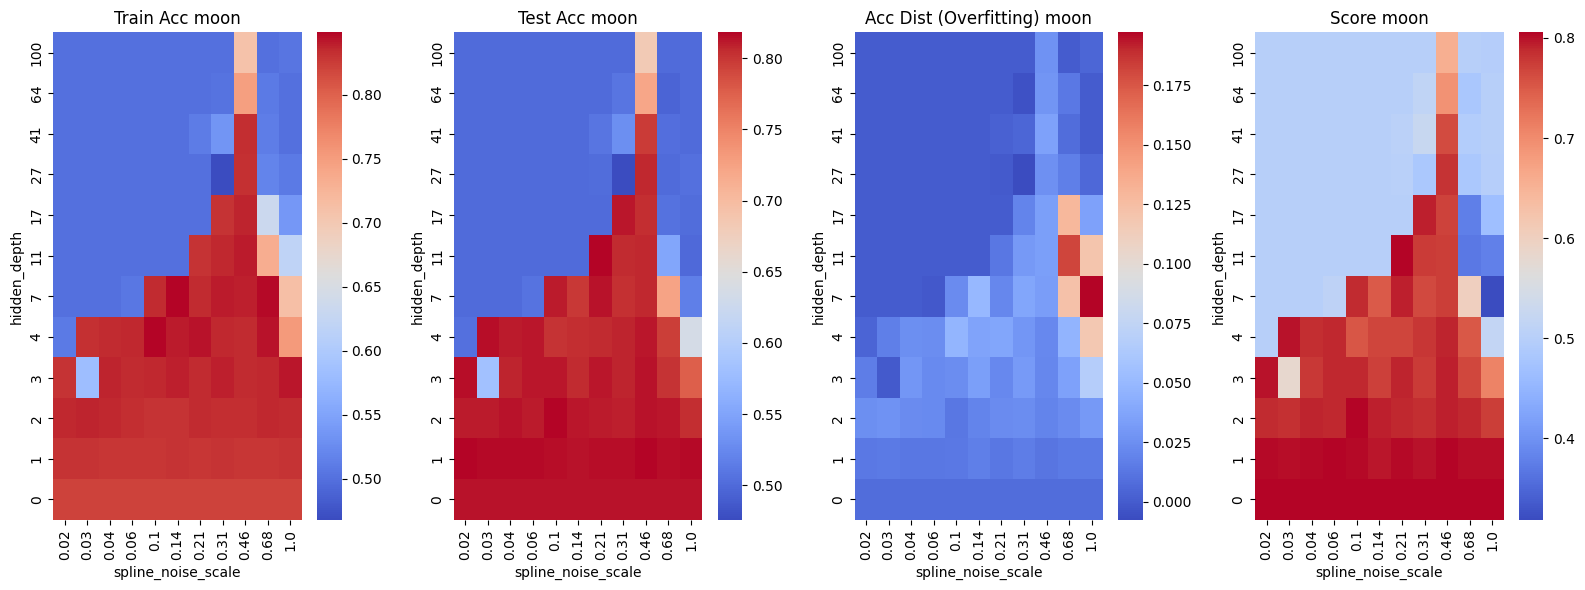

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


for ds in ['random', 'moon']:

    filtered_df = experiment_df
    filtered_df = filtered_df[filtered_df['dataset'] == ds]

    # # Take the last accuracy
    # filtered_df = filtered_df[filtered_df['step'] == 99]


    # take the run with the highest train_acc
    idx = filtered_df.groupby('run_path')['train_acc'].idxmax()
    filtered_df = filtered_df.loc[idx]


    filtered_df["acc_dist"] = filtered_df['train_acc'] - filtered_df['test_acc']


    # calc score 
    k = 1
    filtered_df["score"] = filtered_df['test_acc'] - (k * filtered_df["acc_dist"])

    # Filter out spline_noise_scale outside 0 and 1
    filtered_df = filtered_df[(filtered_df['spline_noise_scale'] >= 0) & (filtered_df['spline_noise_scale'] <= 1)]


    # Step 2: Pivot the DataFrame
    # We will pivot the DataFrame to have 'B' as columns, 'A' as index, and 'C' as values
    train_acc_df = filtered_df.pivot_table(index='hidden_depth', columns='spline_noise_scale', values='train_acc', fill_value=0)
    test_acc_df = filtered_df.pivot_table(index='hidden_depth', columns='spline_noise_scale', values='test_acc', fill_value=0)
    acc_dist_df = filtered_df.pivot_table(index='hidden_depth', columns='spline_noise_scale', values='acc_dist', fill_value=0)
    score_df = filtered_df.pivot_table(index='hidden_depth', columns='spline_noise_scale', values='score', fill_value=0)


    fig, axes = plt.subplots(1, 4, figsize=(16, 6))  # Adjust the figsize as needed


    # Create the first heatmap
    #sns.heatmap(train_acc_df, annot=True, cmap='coolwarm', fmt=".1f", ax=axes[0])  # Create the first heatmap
    sns.heatmap(train_acc_df, cmap='coolwarm', ax=axes[0])  # Create the first heatmap
    axes[0].set_title(f'Train Acc {ds}')  # Set title for the first heatmap
    axes[0].set_ylabel('hidden_depth')  # Set x-label for the first heatmap
    axes[0].set_xlabel('spline_noise_scale')  # Set y-label for the first heatmap
    axes[0].invert_yaxis()

    # Create the second heatmap
    #sns.heatmap(test_acc_df, annot=True, cmap='coolwarm', fmt=".1f", ax=axes[1])  # Create the second heatmap
    sns.heatmap(test_acc_df, cmap='coolwarm', ax=axes[1])  # Create the second heatmap
    axes[1].set_title(f'Test Acc {ds}')  # Set title for the first heatmap
    axes[1].set_ylabel('hidden_depth')  # Set x-label for the second heatmap
    axes[1].set_xlabel('spline_noise_scale')  # Set y-label for the second heatmap
    axes[1].invert_yaxis()

    # Create the second heatmap
    #sns.heatmap(test_acc_df, annot=True, cmap='coolwarm', fmt=".1f", ax=axes[1])  # Create the second heatmap
    sns.heatmap(acc_dist_df, cmap='coolwarm', ax=axes[2])  # Create the second heatmap
    axes[2].set_title(f'Acc Dist (Overfitting) {ds}')  # Set title for the first heatmap
    axes[2].set_ylabel('hidden_depth')  # Set x-label for the second heatmap
    axes[2].set_xlabel('spline_noise_scale')  # Set y-label for the second heatmap
    axes[2].invert_yaxis()

    # Create the second heatmap
    #sns.heatmap(test_acc_df, annot=True, cmap='coolwarm', fmt=".1f", ax=axes[1])  # Create the second heatmap
    sns.heatmap(score_df, cmap='coolwarm', ax=axes[3])  # Create the second heatmap
    axes[3].set_title(f'Score {ds}')  # Set title for the first heatmap
    axes[3].set_ylabel('hidden_depth')  # Set x-label for the second heatmap
    axes[3].set_xlabel('spline_noise_scale')  # Set y-label for the second heatmap
    axes[3].invert_yaxis()


    # Adjust layout
    plt.tight_layout()

    # Show the heatmaps
    plt.show()

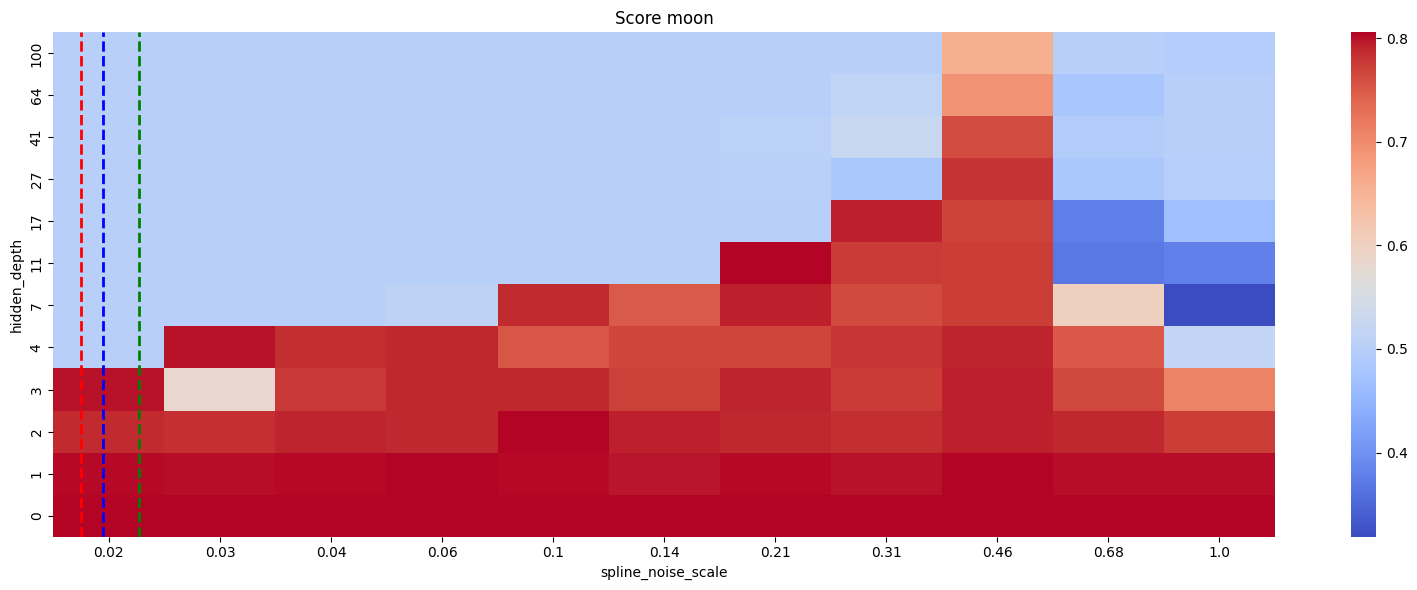

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


#datasets = ['random', 'moon']
datasets = ['moon']
for ds in datasets:

    filtered_df = experiment_df
    filtered_df = filtered_df[filtered_df['dataset'] == ds]

    # # Take the last accuracy
    # filtered_df = filtered_df[filtered_df['step'] == 99]


    # take the run with the highest train_acc
    idx = filtered_df.groupby('run_path')['train_acc'].idxmax()
    filtered_df = filtered_df.loc[idx]


    filtered_df["acc_dist"] = filtered_df['train_acc'] - filtered_df['test_acc']


    # calc score 
    k = 1
    filtered_df["score"] = filtered_df['test_acc'] - (k * filtered_df["acc_dist"])

    # Filter out spline_noise_scale outside 0 and 1
    filtered_df = filtered_df[(filtered_df['spline_noise_scale'] >= 0) & (filtered_df['spline_noise_scale'] <= 1)]




    # Step 2: Pivot the DataFrame
    # We will pivot the DataFrame to have 'B' as columns, 'A' as index, and 'C' as values
    train_acc_df = filtered_df.pivot_table(index='hidden_depth', columns='spline_noise_scale', values='train_acc', fill_value=0)
    test_acc_df = filtered_df.pivot_table(index='hidden_depth', columns='spline_noise_scale', values='test_acc', fill_value=0)
    acc_dist_df = filtered_df.pivot_table(index='hidden_depth', columns='spline_noise_scale', values='acc_dist', fill_value=0)
    score_df = filtered_df.pivot_table(index='hidden_depth', columns='spline_noise_scale', values='score', fill_value=0)


    fig, axes = plt.subplots(1,1,figsize=(16, 6))  # Adjust the figsize as needed



    # Create the second heatmap
    #sns.heatmap(test_acc_df, annot=True, cmap='coolwarm', fmt=".1f", ax=axes[1])  # Create the second heatmap
    sns.heatmap(score_df, cmap='coolwarm')  # Create the second heatmap
    axes.set_title(f'Score {ds}')  # Set title for the first heatmap
    axes.set_ylabel('hidden_depth')  # Set x-label for the second heatmap
    axes.set_xlabel('spline_noise_scale')  # Set y-label for the second heatmap
    axes.invert_yaxis()


    num = 5
    default_0_1 = 0.1 / 2 * num
    default_0_3 = 0.3 / 2 * num
    default_0_5 = 0.5 / 2 * num

    in_dim = 5
    out_dim = 5
    xavier = np.sqrt(6.0/(in_dim+out_dim))
    xavier_in = np.sqrt(1.0/(in_dim))
    kaiming_in = np.sqrt(3.0/(in_dim))

    x_coordinate = 2  # Change this to the desired x position
    axes.axvline(x=default_0_1, color='red', linestyle='--', linewidth=2)
    #axes.axvline(x=default_0_3, color='red', linestyle='--', linewidth=2)
    #axes.axvline(x=default_0_5, color='red', linestyle='--', linewidth=2)
    #axes.axvline(x=xavier, color='blue', linestyle='--', linewidth=2)
    axes.axvline(x=xavier_in, color='blue', linestyle='--', linewidth=2)
    axes.axvline(x=kaiming_in, color='green', linestyle='--', linewidth=2)

    # Adjust layout
    plt.tight_layout()

    # Show the heatmaps
    plt.show()

In [15]:
a1 = 0.8
a2 = 0.5

b1 = 0.7
b2 = 0.5

a = (a2**2)/a1 
b = (b2**2)/b1

print("a", a)
print("b", b)

a 0.3125
b 0.35714285714285715
